In [166]:
from analyticon_fifa.data_loader import MaleData, FemaleData
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind


In [167]:
maledf = MaleData()
femadf = FemaleData()
maledf["female"] = 0
femadf["female"] = 1
df = pd.concat((maledf, femadf), ignore_index=True)
df = df.sort_values(by=["sofifa_id", "year"])
df = df.drop_duplicates(subset=["sofifa_id"], keep="last")

/Users/manolomg/repos/analyticon23/src/analyticon_fifa/data_loader.py:84: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  part = pd.read_csv(path, usecols=USECOLS)


<Axes: ylabel='nationality_name'>

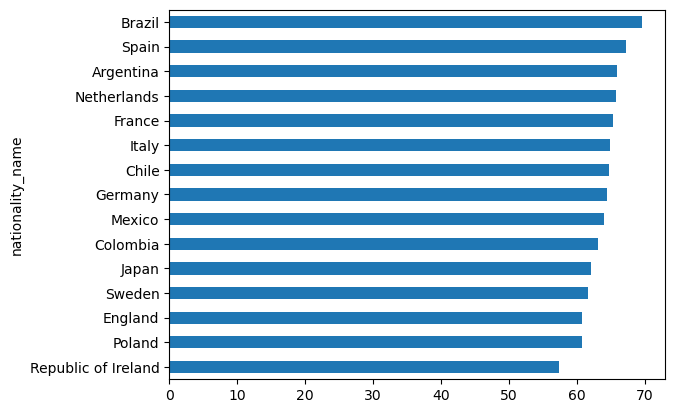

In [168]:
top10_countries = df.groupby("nationality_name")["sofifa_id"].count().nlargest(15)
df[df["nationality_name"].isin(top10_countries.index)].groupby("nationality_name")["overall"].mean().sort_values().plot(kind="barh")

<Axes: ylabel='nationality_name'>

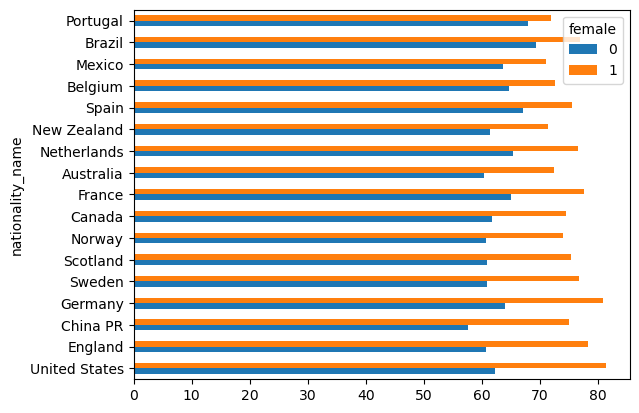

In [192]:
x = df.groupby(["nationality_name", "female"])["overall"].mean().unstack(1)
x = x[x[1].notnull()]
x["diff"] = x[1] - x[0]
x.sort_values(by="diff", inplace=True, ascending=False)
x[[0, 1,]].plot(kind="barh")

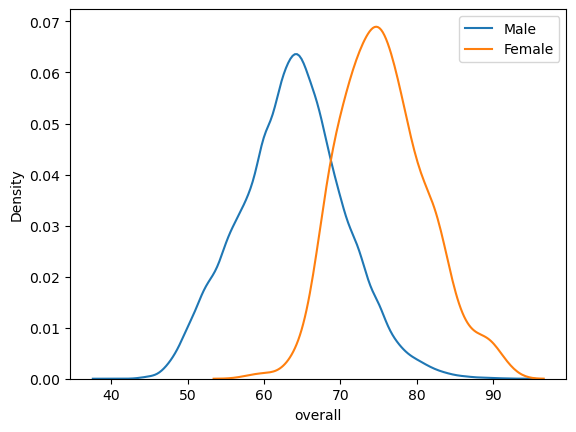

In [169]:
sns.kdeplot(data=df[df["female"] == 0], x="overall", label="Male")
sns.kdeplot(data=df[df["female"] == 1], x="overall", label="Female")
plt.legend()

In [170]:
ttest_ind(
    a=df[df["female"] == 0]["overall"],
    b=df[df["female"] == 1]["overall"],
    equal_var=False,
    alternative="two-sided"
)

TtestResult(statistic=-55.097713892892195, pvalue=5.4930993176417266e-266, df=750.6357305483953)

<Axes: xlabel='age'>

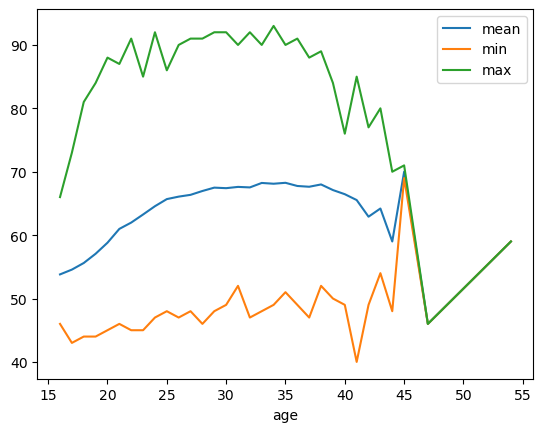

In [171]:
df.groupby("age").agg(mean=("overall", "mean"), min=("overall", "min"), max=("overall", "max")).plot()